### NN Vector Pull for Direction

Oct 31 2023
TJ Kim

##### Summary
Load any NN model. Obtain layer by layer the unit direction vector (against vector of zeros). See if cosine similarity can be used as a metric to measure direction.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user = "FedAvg", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 134.79it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:17<00:00,  4.60it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 2.299 | Train Acc: 10.548% |Test Loss: 2.297 | Test Acc: 10.511% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def matrix_cosine_similarity(mat1, mat2):
    vec1 = mat1.cpu().numpy().flatten()
    vec2 = mat2.cpu().numpy().flatten()
    return cosine_similarity([vec1], [vec2])[0][0]

def get_adv_acc(aggregator, model, batch_size = 500):
    num_clients = len(aggregator.clients)

    # Dataloader for datax
    data_x = []
    daniloader = clients[0].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)

    data_x = torch.stack(data_x)
    victim_idxs = range(num_clients)

    # Save matrix
    test_acc_save = np.zeros([1])
    adv_acc_save = np.zeros([1])

    for c_id in range(1):
        dataloader = load_client_data(clients = aggregator.clients, c_id = c_id, mode = 'test')
        batch_size = min(batch_size, dataloader.y_data.shape[0])

        t1 = Transferer(models_list = [model] * num_clients, dataloader=dataloader)
        t1.generate_victims(victim_idxs)
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10, target = -1,
                                x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                                step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)
        t1.generate_advNN(c_id)
        t1.generate_xadv(atk_type="pgd")
        t1.send_to_victims(victim_idxs)
        test_acc_save[c_id] = t1.orig_acc_transfers[0]
        adv_acc_save[c_id] = t1.adv_acc_transfers[0]

    return test_acc_save, adv_acc_save

def pull_model_from_agg(aggregator):
        
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
    
    # first make the model with empty weights
    new_model = copy.deepcopy(hypotheses[0].model)
    return new_model

In [5]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [6]:
# Find mag norm 
mag_norm_FedAvg2FAT = []
for key in desired_keys: #params_FAT:

    diff = params_FAT[key] - params_FedAvg[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FedAvg2FAT += [diff/torch.norm(diff,p=2)]


In [17]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 10

test_acc_gather = []
adv_acc_gather = []

save_path_FAT150 = 'weights/cifar10/231031_FAT150round/FAT/'

# Test performance of aggregator on data 
aggregator.load_state(dir_path = save_path_FAT150)
aggregator.update_clients()
model_FAT = pull_model_from_agg(aggregator)
acc, adv_acc = get_adv_acc(aggregator, model_FAT)
print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
test_acc_gather+= [np.mean(acc)]
adv_acc_gather += [np.mean(adv_acc)]

for i in range(num_rounds):
    aggregator.mix()
    model_overfit = pull_model_from_agg(aggregator)
    acc, adv_acc = get_adv_acc(aggregator, model_overfit)
    print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
aggregator.update_clients()

model_overfit = pull_model_from_agg(aggregator)
acc, adv_acc = get_adv_acc(aggregator, model_overfit)
print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))


Test acc:  0.8125 adv acc:  0.38750001788139343
round 0 Test acc:  0.800000011920929 adv acc:  0.4124999940395355
round 1 Test acc:  0.800000011920929 adv acc:  0.4124999940395355
round 2 Test acc:  0.800000011920929 adv acc:  0.4124999940395355
round 3 Test acc:  0.800000011920929 adv acc:  0.4124999940395355
round 4 Test acc:  0.800000011920929 adv acc:  0.4124999940395355
++++++++++++++++++++++++++++++
Global..
Train Loss: 0.232 | Train Acc: 93.887% |Test Loss: 0.599 | Test Acc: 79.278% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################
round 5 Test acc:  0.800000011920929 adv acc:  0.38750001788139343
round 6 Test acc:  0.800000011920929 adv acc:  0.38750001788139343
round 7 Test acc:  0.8125 adv acc:  0.4124999940395355
round 8 Test acc:  0.800000011920929 adv acc:  0.375
round 9 Test acc:  0.800000011920929 adv acc:  0.36250001192092896
round 10 Test acc:  0.8125 adv acc:  0.3499999940395355
round 

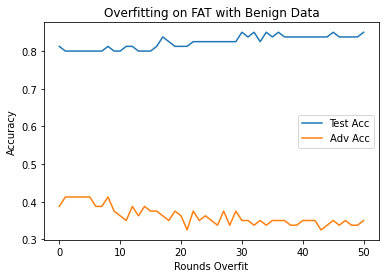

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = range(len(test_acc_gather))  # 100 points from 0 to 10
y1 = test_acc_gather               # Sine function for the first line
y2 = adv_acc_gather             # Cosine function for the second line

# Plotting the lines
plt.plot(x, y1, label='Test Acc')
plt.plot(x, y2, label='Adv Acc')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Accuracy')
plt.title('Overfitting on FAT with Benign Data')

# Adding a legend
plt.legend()

# Display the plot
plt.show()
